[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\13126\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\13126\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\13126\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              precision    recall  f1-score   support

      Action       0.92      0.89      0.90        79
    Dialogue       1.00      0.89      0.94        36
 Information       0.97      0.98      0.97       366

    accuracy                           0.96       481
   macro avg       0.96      0.92      0.94       481
weighted avg       0.96      0.96      0.96       481



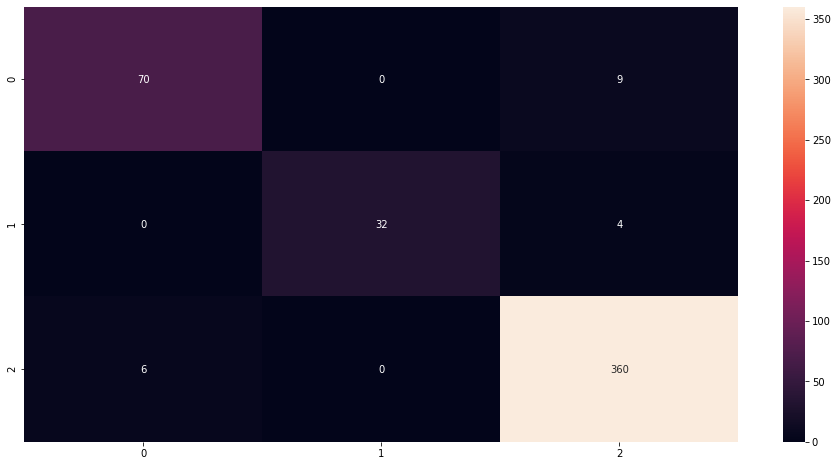

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.model_selection import train_test_split
nltk.download('wordnet')
from sklearn.metrics import confusion_matrix, classification_report


data = pd.read_csv("C:/Users/13126/Downloads/Corporate-messaging-DFE.csv", encoding='latin-1')
data.head() #column text is independant variable for the text classification problem
data.shape
data['category'].value_counts() #removing the exclude category since it has significantly low amount of observations
data['category:confidence'].value_counts() #ignoring observations where the confidence score is less than 1
data = data[(data['category:confidence']==1)&(data['category']!='Exclude')]

#extracting the feature which is the text column and that is being used to reach our target column which is category
feature = data['text']
target = data['category']

#preprocessing and cleaning the text data before passing it to the model building process
feature[0] #first text in the dataset, the text also shows a url that may not convey any meaningful information so may remove it
feature[2] #need to remove the non ascii characters present in the dataset as well

#using regex for text cleaning
stopword = stopwords.words('english')
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
non_ascii_regex = r'[^\x00-\x7F]+'

#writing a function to tokenize the text after preprocessing
def tokenize(text):
    text = re.sub(url_regex, "urlplace", text) #replacing urls by placeholders
    text = re.sub(non_ascii_regex, " ", text) #removing the non ascii characters
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]
    return clean_tokens
    

#exploratory data analysis
#hypothesis testing
#1st hypothesis: the lenght of the text is in each category might be different from each other
#2nd hypothesis: the total URLs present in the text might differ based on category

#hypothesis1
#visualizing pattern in length based on category
data['length'] = data['text'].apply(lambda x: len(word_tokenize(x)))
fig = plt.figure(figsize=(16,8))
sns.boxplot(x='category',y='length', data=data)
#average lenght of text in the dialouge category is comparitvely less than the other two categories

#hypothesis2
data['url_count'] = data['text'].apply(lambda x: len(re.findall(url_regex,x)))
pd.crosstab(data['category'], data['url_count'], normalize = True)
#information category has significantly more number of urlcounts (percentages) than the other two catgories

#creating custom transformers to combine and then pass to ML model
#estimator: an object that learns for the data it is given, using scikit
#using transformers to compute new variables on the existing text data
#calculating the length of each sentence
#oop used

class LengthExtractor(BaseEstimator, TransformerMixin): #custom transformer passed into the ML pipeline
    
    def compute_length(self, text):
        sentence_list = word_tokenize(text)
        return len(sentence_list)
    
    def fit(self, x, y = None):
        return self
    
    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)

class UrlCounter(BaseEstimator, TransformerMixin):
    
    def count_url(self, text):
        urls = re.findall(url_regex, text)
        return len(urls)
    
    def fit(self, x, y=None): #fit function takes in the dataset
        return self
    
    def transform(self, X):
        url_count = pd.Series(X).apply(self.count_url)
        return pd.DataFrame(url_count)
    

#using feature union to combine multiple features or transformers together
#the results of those transformers are then concatenated
#the final output is returned and that feature is then sent to the ML model

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer = tokenize)), 
            ('tfidf', TfidfTransformer())
        ])),
        ('text_len', LengthExtractor()),
        ('url_count', UrlCounter())
    ])),
    
    ('clf', RandomForestClassifier())
])

#Natural Language Processing pipeline created^ used to extract the features

#Model Training
#spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size =0.2, random_state =42 )
pipeline.fit(X_train, y_train)

#Evaluating the created model and extracting the labels
y_pred = pipeline.predict(X_test)
labels = np.unique(y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred, labels = labels), annot = True, fmt = '.0f')
print(classification_report(y_test,y_pred))

#As we can see on the heatmap, the number of misclassifications are significantly less than the correctly predicted outcomes
#i.e on the diagonal of the heatmap hence the model performed very well
#This can also be seen in the classification reportas the precision of the model between 92-97% and
#the accuracy of the ML model is 96%

#Conclusion:
#Created hypothesis to help us navigate new features to predict the data
#Created custom transformers and use this in Feature Union to concatenate the data and further use it in ML
#


    
        